In [1]:
import numpy as np
import pandas as pd
import grid2op
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"
# Backend class to use
try:
    from lightsim2grid.lightSimBackend import LightSimBackend
    BACKEND = LightSimBackend
except ModuleNotFoundError:
    from grid2op.Backend import PandaPowerBackend
    BACKEND = PandaPowerBackend
print("you have loaded "+str(BACKEND))

you have loaded <class 'lightsim2grid.lightSimBackend.LightSimBackend'>


<a class="anchor" id="nutshell"></a>
<h2 style="font-family:'Verdana',sans-serif; color:#1D7874;">Run a scenario and save data with an agent </h2>


In [ ]:
from eval_runner import EvalRunner
import utils
from grid2op.Agent import DoNothingAgent
import state_extractor

agent_save_name = "javaness_agent"
# Pick 1 of 3 settings based on agent_save_name:
env_name = "input_data_test"
env = grid2op.make(env_name)
if agent_save_name == "alert_module_javaness":
    agent_instance = utils.load_agent_from_submission_file(env, "agent_FinalSubmission_javaness")
    add_alert_module = True
    agent_instance.alert_module = DoNothingAgent(env.action_space) # Replace agents alert_module with do nothing
elif agent_save_name == "javaness_agent":
    agent_instance = utils.load_agent_from_submission_file(env, "agent_FinalSubmission_javaness")
    add_alert_module = False
elif agent_save_name == "javaness_agent_mod":
    agent_instance = utils.load_agent_from_submission_file(env, "agent_FinalSubmission_javaness_mod")
    add_alert_module = False

config = {
    "agent_instance": agent_instance,
    "add_alert_module": add_alert_module,
    "agent_save_name": agent_save_name,
    "results_save_dir": "stored_agents/test",
    "nb_episodes": 2, # 208
    "env_name": env_name,
    "reward_class": None,
    "episode_config_path": "config_test.json",
    "agent_seeds": None,
    "env_seeds": None,
    "episode_ids": None,
    "max_iter": None,
    "alert_module_kwargs": {
        "state_extractor_class": state_extractor.RhoMaintenanceDatesPower,
        "model_load_path": "experiments/java_comp_maintenance_xxxl_3x0/20231120-142207",
        "nn_model": True,
        "alert_threshold": None,
        },
}
EvalRunner(**config).run()

<a class="anchor" id="nutshell"></a>
<h2 style="font-family:'Verdana',sans-serif; color:#1D7874;">Compare results: agent vs baseline </h2>

In [2]:
import pandas as pd

# load data
results_df = pd.read_csv(
    #"stored_agents/test_set/alert_module_javaness_ctrl_th_05_nn_save/results.csv", # 0.5 old state extractor
    #"stored_agents/test_set/alert_module_javaness/20231129-142939/results.csv", # 0.3 new SE broken
    #"stored_agents/test_set/alert_module_javaness/20231201-100030/results.csv", # 0.7 new SE broken
    #"stored_agents/test_set/alert_module_javaness/20231122-172808/results.csv", # old state extractor dyn th broken
    "stored_agents/test_set/alert_module_javaness_old/20231128-103023/results.csv", # minimal dyn th, new state extractor new traning data! broken? I think not actually
    #"stored_agents/test_set/javaness_agent_mod_save/results.csv",
    index_col=0)

results_df_bs = pd.read_csv(
    "stored_agents/test_set/javaness_agent_save/results.csv",
    index_col=0)

# Calc mean rewards and mean n steps
idx = results_df["reward"].index.intersection(results_df_bs["reward"].index)
results_df = results_df.loc[idx]
results_df_bs = results_df_bs.loc[idx]

sum_reward = results_df["reward"]
sum_reward_bs = results_df_bs["reward"]
mean = round(sum_reward.mean(), 3)
mean_bs = round(sum_reward_bs.mean(), 3)
mean_steps = results_df["n_steps"].mean()
mean_steps_bs = results_df_bs["n_steps"].mean()
# Get n times performance matches or differs
sum_reward = sum_reward.round(3) # round before comparing
sum_reward_bs = sum_reward_bs.round(3)
n_agent = (sum_reward > sum_reward_bs).sum()
n_equal = (sum_reward == sum_reward_bs).sum()
n_baseline = (sum_reward < sum_reward_bs).sum()

grid_failure = results_df["n_steps"] < 2016
n_blackouts = grid_failure.sum()
r_blackout = results_df[grid_failure]["reward"]
r_blackout_bs = results_df_bs[grid_failure]["reward"]
mean_blackout = round(r_blackout.mean(), 3)
mean_blackout_bs = round(r_blackout_bs.mean(), 3)

r_blackout = r_blackout.round(3)
r_blackout_bs = r_blackout_bs.round(3)
n_agent_blackout = (r_blackout > r_blackout_bs).sum()
n_equal_blackout = (r_blackout == r_blackout_bs).sum()
n_baseline_blackout = (r_blackout < r_blackout_bs).sum()

# Display dfs side by side
results_df_copy = results_df.copy()
results_df_bs_copy = results_df_bs.copy()

results_df_copy.columns = pd.MultiIndex.from_tuples(
    zip(['Agent', ''], 
        results_df.columns))
results_df_bs_copy.columns = pd.MultiIndex.from_tuples(
    zip(['Baseline', ''], 
        results_df_bs.columns))
display(pd.concat([results_df_copy.round(3), results_df_bs_copy.round(3)], axis=1))
# Print metrics
print(f"N times agent beat baseline: {n_agent}")
print(f"N times equal: {n_equal}")
print(f"N times baseline beat agent: {n_baseline}")
print(f"Mean reward agent: {mean}")
print(f"Mean reward baseline: {mean_bs}")
print(f"Mean steps agent: {mean_steps}")
print(f"Mean steps baseline: {mean_steps_bs}")

print(f"\nN blackouts: {n_blackouts}")
print(f"N times agent beat baseline blackout: {n_agent_blackout}")
print(f"N times equal blackout: {n_equal_blackout}")
print(f"N times baseline beat agent blackout: {n_baseline_blackout}")
print(f"Mean reward agent blackout: {mean_blackout}")
print(f"Mean reward baseline blackout: {mean_blackout_bs}")

"""
# Get chronics where agent and/or baseline failed to predict blackout
index_fail_predict_blackout = results_df[grid_failure][results_df["reward"] < -2].index
index_fail_predict_blackout_bs = results_df_bs[grid_failure][results_df_bs["reward"] < -2].index
index_both_fail = index_fail_predict_blackout.intersection(index_fail_predict_blackout_bs)
index_only_agent_fail = index_fail_predict_blackout.drop(index_both_fail)
index_only_baseline_fail = index_fail_predict_blackout_bs.drop(index_both_fail)
"""

FileNotFoundError: [Errno 2] No such file or directory: 'stored_agents/test_set/alert_module_javaness/20231128-103023/results.csv'

<a class="anchor" id="nutshell"></a>
<h2 style="font-family:'Verdana',sans-serif; color:#1D7874;">Agent vs baseline behaviour case study </h2>

2035-06-11_7
Your agent is confident on average 98.0 to not raise alerts.
The baseline agent is confident on average 100.0 to not raise alerts.


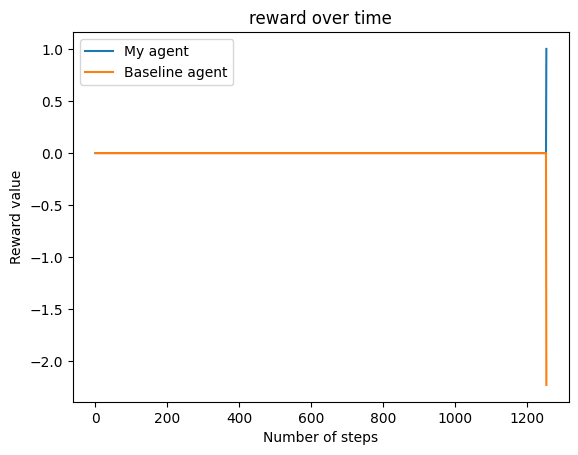

Attack lines and time:
[(array([15]), 3), (array([19]), 56), (array([8]), 162), (array([14]), 232), (array([3]), 361), (array([17]), 589), (array([13]), 604), (array([16]), 842), (array([7]), 919), (array([19]), 998), (array([9]), 1025), (array([10]), 1166), (array([8]), 1249)]


In [47]:
from grid2op.Episode import EpisodeData

def get_attacked_lines_and_time(obs_list):
    attacked_lines_time = []
    for attack_time, obs in enumerate(obs_list):
        attacked_lines = np.where(obs.time_since_last_attack == 0)[0]
        if len(attacked_lines) == 0:
            continue
        attacked_lines_time.append((attacked_lines, attack_time))
    return attacked_lines_time

def style_specific_cells(x, idx_list):
    color = 'background-color: orange'
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    for row, col in idx_list:
        df.iloc[row, col] = color
    return df

# Paths to agent and baseline
agent_path = "stored_agents/test_set/alert_module_javaness_ctrl_th_05_nn_save"
#agent_path = "stored_agents/test/alert_module_javaness/20231201-151042"
agent_path_bs = "stored_agents/test_set/javaness_agent_save"


chronic = "2035-01-08_3" # agent
#chronic = "2035-01-08_21" # both fail. Javaness stops alerting before attack leading to blackout
chronic = "2035-09-10_19" # bs schools agent. No attack at last timestep. 
# failure cases alert module:
#chronic = "2035-06-18_5"
#chronic = "2035-01-08_29"
#chronic = "2035-01-15_15"

# "Strange" failures javaness - explained!
#chronic = "2035-03-26_4" # No attack at final step. Javaness stops alerting before attack leading to blackout
#chronic = "2035-02-19_12" # probably attack at last timestep
#chronic = "2035-03-05_29" # probably attack at last timestep
#chronic = "2035-03-19_0" # No attack at final step. Javaness stops alerting before attack leading to blackout
chronic = "2035-06-11_7" # No attack at final step. Javaness stops alerting before attack leading to blackout
#chronic = "2035-12-10_10" # Attack happens at final (blackout) timestep. obs.time_since_last_attack is probably not updated at blackout, so attack doesnt appear in visualization

print(chronic)

env = grid2op.make("input_data_test",test=False,backend=BACKEND()) # only used to get env info

episode_data = EpisodeData.from_disk(agent_path, name=chronic)
episode_data_bs = EpisodeData.from_disk(agent_path_bs, name=chronic)
nb_time_step = len(episode_data) - 1

mean_percentage_cnfident_rate=np.mean([r['confidence_rate'] for r in episode_data.other_rewards])*100
print(f"Your agent is confident on average {str(np.round(mean_percentage_cnfident_rate))} to not raise alerts.")

mean_percentage_cnfident_rate_bs=np.mean([r['confidence_rate'] for r in episode_data_bs.other_rewards])*100
print(f"The baseline agent is confident on average {str(np.round(mean_percentage_cnfident_rate_bs))} to not raise alerts.")

plt.figure()
plt.title("reward over time")
plt.plot(episode_data.rewards, label="My agent")
plt.plot(episode_data_bs.rewards, label="Baseline agent")
plt.legend()
plt.xlabel("Number of steps")
plt.ylabel("Reward value")
plt.show()

alerts = [obs.active_alert for obs in episode_data.observations]
#alerts = [a.raise_alert for a in episode_data.actions]
alerts_df = pd.DataFrame(alerts)
alerts_df.columns = env.name_line[env.alertable_line_ids]
#display(alerts_df.head())

alerts_bs = [obs.active_alert for obs in episode_data_bs.observations]
#alerts_bs = [a.raise_alert for a in episode_data_bs.actions]
alerts_df_bs = pd.DataFrame(alerts_bs)
alerts_df_bs.columns = env.name_line[env.alertable_line_ids]

# Actions happen 1 step before alerts are observed - shift 1 step back:
alerts_df = alerts_df.shift(periods=-1, axis=0, fill_value=False)
alerts_df_bs = alerts_df_bs.shift(periods=-1, axis=0).fillna(False)

data = alerts_df.astype('int').sum(axis=0)
data_bs = alerts_df_bs.astype('int').sum(axis=0)

pio.renderers.default = "notebook_connected"
fig = go.Figure()
fig.add_bar(x=data.index, y=data.values, name="My agent")
fig.add_bar(x=data_bs.index, y=data_bs.values, name="Baseline")
fig.update_layout(xaxis_title="Lines", yaxis_title="Nof raise alerts")
fig.show()

obs_list = [obs for obs in episode_data.observations]
obs_list_bs = [obs for obs in episode_data_bs.observations]

attacked_lines_time = get_attacked_lines_and_time(obs_list)
print(f"Attack lines and time:\n{attacked_lines_time}")
# Testing that attack times are the same:
attacked_lines_time_bs = get_attacked_lines_and_time(obs_list_bs)
for elem, elem2 in zip(attacked_lines_time, attacked_lines_time_bs):
    np.testing.assert_array_equal(elem[0], elem2[0])
    assert elem[1] == elem2[1]

"""plot_helper = PlotMatplot(env.observation_space)
line_ids = [int(i) for i in range(env.n_line)]
plot_helper.plot_info(line_values=line_ids)
plot_helper.plot_obs(obs_list[15])"""

orange = [{'selector': 'th', 'props': 'background-color: orange'}]
#alerts_at_step = alerts_df.astype('int').T.style.background_gradient(cmap ='coolwarm', axis=None).apply(style_specific_cells, idx_list=attacked_lines_time, axis=None)
#alerts_at_step_bs = alerts_df_bs.astype('int').T.style.background_gradient(cmap ='coolwarm', axis=None).apply(style_specific_cells, idx_list=attacked_lines_time, axis=None)
alerts_at_step = (alerts_df * 1).T.style.background_gradient(cmap ='coolwarm', axis=None).apply(style_specific_cells, idx_list=attacked_lines_time, axis=None)
alerts_at_step_bs = (alerts_df_bs * 1).T.style.background_gradient(cmap ='coolwarm', axis=None).apply(style_specific_cells, idx_list=attacked_lines_time, axis=None)

display(alerts_at_step)
display(alerts_at_step_bs)

print()